M931 : Deep Learning for NLP | Winter Semester 2023/24 | Student ID: lt12200010 | Student Name: Kleopatra Karapanagiotou

Assignment 4: #Finetuning [GreekBERT](https://huggingface.co/nlpaueb/bert-base-greek-uncased-v1) and [DistillGreekBERT ](https://huggingface.co/EftychiaKarav/DistilGREEK-BERT)for Multiclass Sentiment Analysis on Greek tweets

#Installations | Library imports

In [1]:
!pip install demoji transformers torchtext==0.6.0 accelerate -U


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 36.5 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.16.2
    Uninstalling torchtext-0.16.2:
      Successfully uninstalled torchtext-0.16.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.1
    Uninstalling transformers-4.38.1:
      Successfully uninstalled transformers-4.38.1


In [2]:
import re
import string
import demoji
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
import pandas as pd
import random
import time
import datetime
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torchtext
import torch.nn.functional as F
import matplotlib.pyplot as plt
from numpy import interp
from itertools import cycle
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup, AutoTokenizer, AutoModel




[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#Set up GPU for training

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

There are 2 GPU(s) available.
Device name: Tesla T4


#Helper funcs

In [4]:
# A function that sets seed for reproducibility
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

# A function that calculates time in seconds and returns a string in the form hh:mm:ss
def calculate_time(elapsed_time):

    # Round to the nearest second
    elapsed_rounded = int(round((elapsed_time)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))



#Funcs for text preprocessng

In [5]:
def read_explore_clean_dataset(dataset_path, text_column='Text', label_column='Sentiment'):
    # Load the dataset
    df = pd.read_csv(dataset_path, encoding='utf-8')
    print(df.info())
    # Count the number of samples in each class
    class_counts = df[label_column].value_counts()

    # Clean the dataset
    # Drop duplicate rows
    df = df.drop_duplicates(subset=[text_column, label_column])

    # Drop rows with NaN values
    df = df.dropna(subset=[text_column, label_column])

    # Reset index after dropping rows
    df = df.reset_index(drop=True)
    print('Dataframe checked for NaN values and duplicates!')

    return df

def replaceMultiple(main, replacements, new):
  for elem in replacements:
    if elem in main:
      main = main.replace(elem, new)
  return main

def normalize(x):
  x = replaceMultiple(x, ['ά', 'ὰ', 'ἀ','ἁ','ἂ','ἃ','ἄ','ἅ','ἆ','ἇ','ᾰ','ᾱ','ᾲ','ᾳ','ᾴ','ᾶ','ᾷ'], 'α')
  x = replaceMultiple(x, ['έ','ὲ','ἐ','ἑ','ἒ','ἓ','ἔ','ἕ'], 'ε')
  x = replaceMultiple(x, ['ή','ὴ','ἠ','ἡ','ἢ','ἣ','ἤ','ἥ','ἦ','ἧ','ῂ','ῃ','ῄ','ῆ','ῇ'], 'η')
  x = replaceMultiple(x, ['ί','ὶ','ἰ','ἱ','ἲ','ἳ','ἴ','ἵ','ἶ','ἷ','ῐ','ῑ','ῒ','ΐ','ῖ','ῗ'], 'ι')
  x = replaceMultiple(x, ['ὸ','ό','ὀ','ὁ','ὂ','ὃ','ὄ','ὅ'], 'ο')
  x = replaceMultiple(x, ['ύ','ὺ','ΰ', 'ϋ','ὐ','ὑ','ὒ','ὓ','ὔ','ὕ','ὖ','ὗ','ῠ','ῡ','ῢ','ΰ','ῦ'], 'υ')
  x = replaceMultiple(x, ['ώ','ὼ','ῶ','ῲ','ῳ','ῴ','ῶ','ῷ','ὠ','ὡ','ὢ','ὣ','ὤ','ὥ','ὦ','ὧ'], 'ω')
  return x

def sep_punc(x):
    punc = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~؛،؟؛.»«”'
    out = []
    for char in x:
        if char in punc:
            out.append(' ' + char + ' ')
        else:
            out.append(char)
    return ''.join(out)

def remove_emojis(text):
    return demoji.replace(text, '')

def preprocess_text_first_step(text):
    # Remove retweets
    text = re.sub(r'^RT[\s]+', '', text, flags=re.IGNORECASE)
    # Remove usernames @
    text = re.sub(r'@[^\s]+', '', text)
    # Remove URLs
    text = re.sub(r'https\S+', '', text)
    url_words = ['url', 'URL', 'html', 'HTML', 'http', 'HTTP']
    for u in url_words:
        text = re.sub(u, '', text)
    return text

def preprocess_text_second_step(text):
    text=normalize(text)
  # Separate punctuation characters
    text = sep_punc(text)
    # Remove punctuation characters
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)
    # Remove Latin characters
    text = re.sub(r'[a-zA-Z]+', '', text)
    # Remove numbers
    text = re.sub(r'\b\d+\b', '', text)
    return text

def preprocess_text_third_step(text):

    text = str(text).lower().strip()
    text = remove_emojis(text)
   # remove the extra whitespace
    text = re.sub(' +', ' ', text)

    return text

def preprocess_dataframe(df,Text):
    # Apply the first step of preprocessing and capture the character length
    df[Text] = df[Text].apply(preprocess_text_first_step)

    # Apply the second step of preprocessing
    df[Text] = df[Text].apply(preprocess_text_second_step)

    # Apply the third step of preprocessing
    df[Text] = df[Text].apply(lambda x: preprocess_text_third_step(x))


    return df

def postprocessing(df, text_column='Text'):
    # Check for empty lists in the DataFrame
    empty_lists = df[text_column].apply(lambda x: len(x) == 0)
    print("\nNumber of rows with empty lists:", empty_lists.sum())

    # Drop rows with empty lists and reset the index
    df.drop(df[empty_lists].index, inplace=True)
    df.reset_index(drop=True, inplace=True)
    print("\nShape after postprocessing:", df.shape)
    # Return the updated DataFrame
    return df

In [6]:
def get_columns(dataframe, Text, Sentiment):

    # Get only the columns we are interested in
    dataset = dataframe[[Text, Sentiment]]

    # Check the distribution of classes
    distribution = dataset[Sentiment].value_counts() / dataset.shape[0]
    print('Distribution of data in classes:')
    print(distribution)

    # Apply the pre-processing function to the dataframe containing the text (feature column)
    dataset = preprocess_dataframe(dataset,Text)
    print('\nText done pre-processing!')

    # Apply post-processing for removing empty rows after preprocessing
    dataset = postprocessing(dataset, text_column='Text')

    # Divide the X and y values
    X = dataset[Text]
    y = dataset[Sentiment]
    sentiment_mapping = {'NEUTRAL': 0, 'POSITIVE': 1, 'NEGATIVE': 2}
    y = y.map(sentiment_mapping)
    # Concatenate the X,Y data
    new_dataframe = pd.concat([X, y], axis=1)

    return new_dataframe

#Funcs for evaluation

In [7]:
# Calculates the accuracy per batch, used in the train_model and evaluate_model functions
def accuracy(preds, y_true):

  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = y_true.flatten()
  acc = np.sum(pred_flat == labels_flat) / len(labels_flat)

  return acc

# A function that plots the confusion matrix with colors and titles
def show_confusion_matrix(confusion_matrix):

  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Labels')
  plt.xlabel('Predicted Labels')


# A function that calculates all the metrics using the validation/test set
def calculate_metrics(y_true, preds):
    print('\nCalculating metrics...')

    # Move tensors to CPU if they are on GPU
    if torch.is_tensor(y_true) and y_true.is_cuda:
        y_true = y_true.cpu()
    if torch.is_tensor(preds) and preds.is_cuda:
        preds = preds.cpu()

    # Convert tensors to NumPy arrays
    y_true = y_true.numpy() if torch.is_tensor(y_true) else y_true
    preds = preds.numpy() if torch.is_tensor(preds) else preds

    # Calculate the accuracy of the model
    acc = accuracy_score(y_true, preds)

    # Calculate general precision, recall, F1 score of the model and of each class
    precision, recall, fscore, support = score(y_true, preds)
    print('Accuracy: {}'.format(acc))
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F1 score: {}'.format(fscore))
    print('Support: {}'.format(support))

    # Print classification report
    class_names = ['neutral', 'positive', 'negative']
    print(classification_report(y_true, preds, target_names=class_names))

    cm = confusion_matrix(y_true, preds)
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    show_confusion_matrix(df_cm)


#Set up pretrained GreekBERT model and tokenizer

In [8]:
# Define the pre-trained model from Hugging Face and its tokenizer
model_name = "nlpaueb/bert-base-greek-uncased-v1"
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case = True)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/530k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Set up pretrained DistilGreekBERT and Tokenizer

In [9]:
#distil_model_name = "EftychiaKarav/DistilGREEK-BERT"
#distil_tokenizer = AutoTokenizer.from_pretrained(distil_model_name, do_lower_case = True)

This is a class initializing a Bert-base model with an additional linear layer on top of it, which uses the embedding vector of size 768 from the [CLS] token and then generates as output the number of the classes through a linear layer (out). The forward function returns the logits for each class.

In [10]:
# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, bert_model_name, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 3

        # Instantiate BERT model
        self.bert = AutoModel.from_pretrained(bert_model_name)


        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            #nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

#Data

In [11]:
train='/kaggle/input/ys19-2023-assignment-4a/train_set.csv'
val='/kaggle/input/ys19-2023-assignment-4a/valid_set.csv'


#Data preparation (train and validation)

In [12]:
# Prepare the training dataset
print('------ Preparing the training dataset... ------')

# Opens, reads, checks for duplicates and removes missing values
df_train  = read_explore_clean_dataset(train)

# Preprocess and resample dataset and return a new cleaned one
train_dataframe = get_columns(df_train,'Text','Sentiment')

# Save the testing data into csv format
train_dataframe.to_csv("train.csv", index=False)
print('The training dataset is ready and saved into csv format!')

# Prepare the validation dataset
print('\n------ Preparing the validation dataset... ------')

# Opens, reads, checks for duplicates and removes missing values
df_val = read_explore_clean_dataset(val)

# Preprocess and resample dataset and return a new cleaned one
valid_dataframe = get_columns(df_val, 'Text', 'Sentiment')

# Save the testing data into csv format
valid_dataframe.to_csv("validation.csv", index=False)
print('The validation dataset is ready and saved into csv format!')

------ Preparing the training dataset... ------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36630 entries, 0 to 36629
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   New_ID     36630 non-null  int64 
 1   Text       36630 non-null  object
 2   Sentiment  36630 non-null  object
 3   Party      36630 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.1+ MB
None
Dataframe checked for NaN values and duplicates!
Distribution of data in classes:
Sentiment
NEUTRAL     0.333333
NEGATIVE    0.333333
POSITIVE    0.333333
Name: count, dtype: float64


/tmp/ipykernel_27/708372891.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[Text] = df[Text].apply(preprocess_text_first_step)
/tmp/ipykernel_27/708372891.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[Text] = df[Text].apply(preprocess_text_second_step)
/tmp/ipykernel_27/708372891.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda


Text done pre-processing!

Number of rows with empty lists: 14

Shape after postprocessing: (36616, 2)
The training dataset is ready and saved into csv format!

------ Preparing the validation dataset... ------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5232 entries, 0 to 5231
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   New_ID     5232 non-null   int64 
 1   Text       5232 non-null   object
 2   Sentiment  5232 non-null   object
 3   Party      5232 non-null   object
dtypes: int64(1), object(3)
memory usage: 163.6+ KB
None
Dataframe checked for NaN values and duplicates!
Distribution of data in classes:
Sentiment
POSITIVE    0.333333
NEGATIVE    0.333333
NEUTRAL     0.333333
Name: count, dtype: float64


/tmp/ipykernel_27/708372891.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[Text] = df[Text].apply(preprocess_text_first_step)
/tmp/ipykernel_27/708372891.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[Text] = df[Text].apply(preprocess_text_second_step)



Text done pre-processing!

Number of rows with empty lists: 1

Shape after postprocessing: (5231, 2)
The validation dataset is ready and saved into csv format!


/tmp/ipykernel_27/708372891.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[Text] = df[Text].apply(lambda x: preprocess_text_third_step(x))
/tmp/ipykernel_27/708372891.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(df[empty_lists].index, inplace=True)


**BERT Tokenizer**
In order to apply the pre-trained BERT, we must use the tokenizer provided by the library. This is because (1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.

In addition, we are required to add special tokens to the start and end of each sentence, pad & truncate all sentences to a single constant length, and explicitly specify what are padding tokens with the "attention mask".

The encode_plus method of BERT tokenizer will:

(1) split our text into tokens,

(2) add the special [CLS] and [SEP] tokens, and

(3) convert these tokens into indexes of the tokenizer vocabulary,

(4) pad or truncate sentences to max length, and

(5) create attention mask.

In [13]:
# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )

        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [14]:
# Open and read the new cleaned dataframes
train_dataframe = pd.read_csv('train.csv', sep=',')
valid_dataframe = pd.read_csv('validation.csv', sep=',')

# Concatenate the train and validation data
all_tweets = np.concatenate([train_dataframe.Text.values, valid_dataframe.Text.values])

# Encode the concatenated data
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_tweets]
#print(encoded_tweets[0])
print(tokenizer.convert_ids_to_tokens(encoded_tweets[0]))
# Find the maximum length
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

['[CLS]', 'απολυμανση', 'κορ', '##ιοι', 'απε', '##ντο', '##μω', '##ση', 'κορ', '##ιος', 'απολυμανσει', '##ς', 'κορ', '##ιος', 'την', 'κυριακη', 'κουλ', '##ης', 'τσιπρα', 'κορ', '##ιοι', 'απολυμανση', 'καταπολεμηση', 'κορ', '##ιων', 'απε', '##ντο', '##μω', '##ση', 'για', 'κορ', '##ιους', '[SEP]']
Max length:  95


In [15]:
MAX_LEN = 95

# Get the texts and their labels from the training and validation data
X_train = train_dataframe.Text.values
y_train = train_dataframe.Sentiment.values

X_val = valid_dataframe.Text.values
y_val = valid_dataframe.Sentiment.values

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X_train[0]])[0].squeeze().numpy())
print('Original: ', X_train[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Original:  απολυμανση κοριοι απεντομωση κοριος απολυμανσεις κοριος την κυριακη κουλης τσιπρα κοριοι απολυμανση καταπολεμηση κοριων απεντομωση για κοριους
Token IDs:  [101, 24023, 1643, 4314, 1294, 2108, 4651, 506, 1643, 2251, 31429, 278, 1643, 2251, 350, 933, 9269, 415, 2269, 1643, 4314, 24023, 4109, 1643, 781, 1294, 2108, 4651, 506, 353, 1643, 7418, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


#Create PyTorch DataLoader

In [16]:
# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 32

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

#Training and evaluate function

In [17]:
def train(model, train_dataloader, val_dataloader, epochs=4, evaluation=False):
    """Train the BertClassifier model."""

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Measure the elapsed time of each epoch
        t0_epoch = time.time()
        # Reset tracking variables at the beginning of each epoch
        total_loss = 0
        correct_predictions_train = 0
        total_predictions_train = 0
        # Put the model into the training mode
        model.train()
        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            # Load batch to GPU
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
            # Zero out any previously calculated gradients
            model.zero_grad()
            # Perform a forward pass. This will return logits.
            logits = model(b_input_ids, b_attn_mask)
            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            total_loss += loss.item()
            # Perform a backward pass to calculate gradients
            loss.backward()
            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()
            # Calculate the number of correct predictions in this batch
            _, predicted = torch.max(logits, 1)
            correct_predictions_train += (predicted == b_labels).sum().item()
            total_predictions_train += b_labels.size(0)

        # Calculate the average training loss and accuracy for this epoch
        avg_train_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        train_accuracy = correct_predictions_train / total_predictions_train * 100
        train_accuracies.append(train_accuracy)

        # Calculate elapsed time for the epoch
        training_time = time.time() - t0_epoch

        # =======================================
        #               Evaluation
        # =======================================
        if evaluation:
            val_loss, val_accuracy = evaluate(model, val_dataloader)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

        # Print the epoch statistics
        print(f"Epoch {epoch_i + 1}/{epochs}:")
        print(f"  Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}% | Time Elapsed: {training_time:.2f} seconds")
        if evaluation:
            print(f"  Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%")
        print("-" * 50)

    print("Training complete!")
    # Plot the learning curves
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    if evaluation:
        plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.xticks(range(1, epochs + 1))  # Set discrete epoch values on x-axis
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
    if evaluation:
        plt.plot(range(1, epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.xticks(range(1, epochs + 1))  # Set discrete epoch values on x-axis
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    return model


def evaluate(model, val_dataloader):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()
    # Tracking variables
    val_accuracy = []
    val_loss = []
    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())
        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()
        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)
    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)
    return val_loss, val_accuracy

def bert_predict_val(model, val_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()
    all_logits = []
    all_labels = []
    # For each batch in our test set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)
        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
        all_labels.append(b_labels)
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)
    # Concatenate labels from each batch
    all_labels = torch.cat(all_labels, dim=0)
    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()
    y_pred = np.argmax(probs, axis=1)
    calculate_metrics(all_labels, y_pred)




#Prepare parameters for training and evaluation

In [18]:
def initialize_model(bert_model_name,epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    bert_classifier = BertClassifier(bert_model_name,freeze_bert=False)

    # Tell PyTorch to run the model on GPU
    bert_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=2e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs
    loss_fn = nn.CrossEntropyLoss()

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler, loss_fn

In [19]:
set_seed(42)    # Set seed for reproducibility
bert_classifier, optimizer, scheduler, loss_fn = initialize_model(model_name,epochs=2)


pytorch_model.bin:   0%|          | 0.00/454M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


#Train and Predict

Start training...

Epoch 1/2:
  Train Loss: 1.0843 | Train Accuracy: 38.16% | Time Elapsed: 546.46 seconds
  Val Loss: 1.0640 | Val Accuracy: 39.81%
--------------------------------------------------
Epoch 2/2:
  Train Loss: 1.0471 | Train Accuracy: 42.52% | Time Elapsed: 552.75 seconds
  Val Loss: 1.0477 | Val Accuracy: 42.86%
--------------------------------------------------
Training complete!


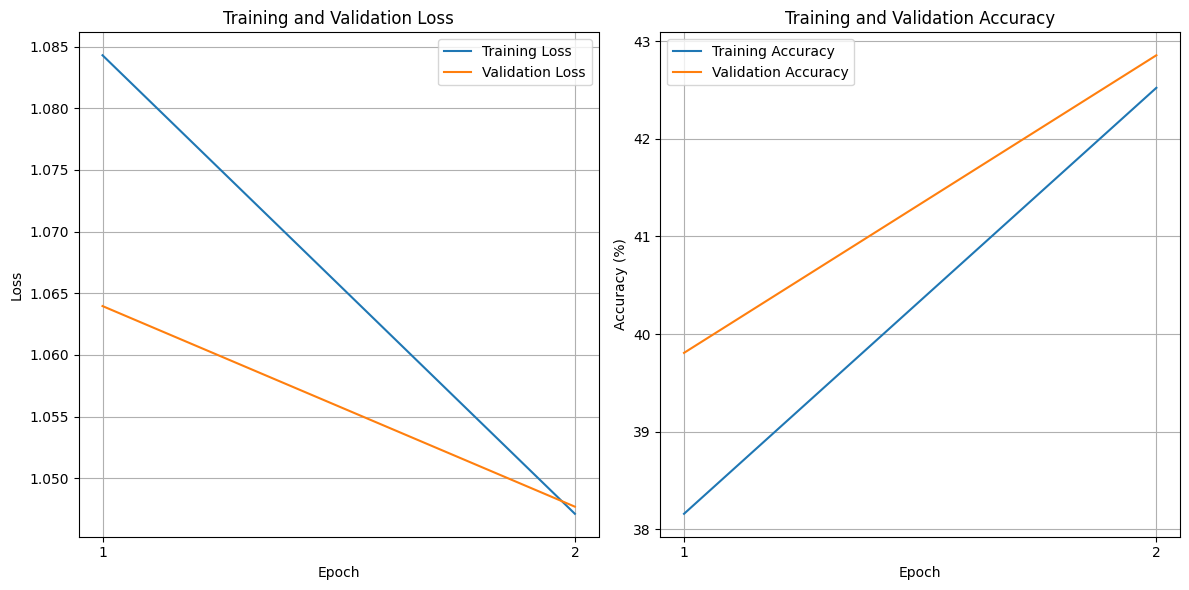


Calculating metrics...
Accuracy: 0.42821640221754925
Precision: [0.47416413 0.42362525 0.4122807 ]
Recall: [0.26850258 0.47706422 0.53899083]
F1 score: [0.34285714 0.44875944 0.46719682]
Support: [1743 1744 1744]
              precision    recall  f1-score   support

     neutral       0.47      0.27      0.34      1743
    positive       0.42      0.48      0.45      1744
    negative       0.41      0.54      0.47      1744

    accuracy                           0.43      5231
   macro avg       0.44      0.43      0.42      5231
weighted avg       0.44      0.43      0.42      5231



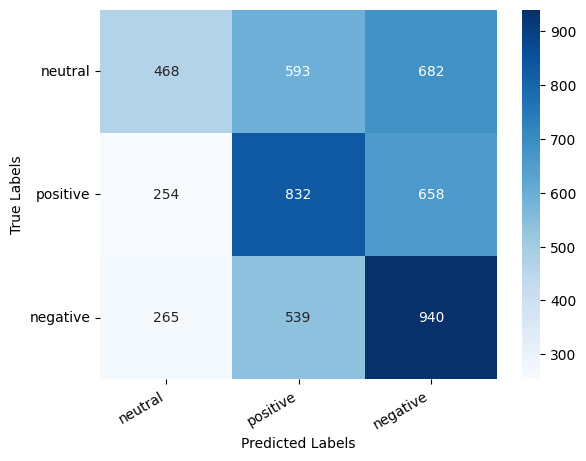

In [20]:
trained_model=train(bert_classifier, train_dataloader, val_dataloader, epochs=2, evaluation=True)

bert_predict_val(trained_model,val_dataloader)

#Save finetuned model

In [21]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`. this is not applicable to the custom Bertclassifier so i will save the finetuned model with torch.save
# They can then be reloaded using `from_pretrained()`
model_to_save = trained_model.module if hasattr(trained_model, 'module') else trained_model  # Take care of distributed/parallel training
torch.save(model_to_save, 'fine_tuned_grBERT_model.pt')
tokenizer.save_pretrained(output_dir)


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json',
 './model_save/tokenizer.json')

Load the finetuned model

In [22]:
model=torch.load('fine_tuned_grBERT_model.pt')
tokenizer = tokenizer.from_pretrained(output_dir)
model.to(device)

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(35000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

#Prepare test set

In [23]:
def get_text(dataframe, text_column):

    # Apply the pre-processing function to the text column
    dataframe = preprocess_dataframe(dataframe,text_column)
    print('\nText done pre-processing!')

    return dataframe[text_column]

In [24]:
# Prepare the testing dataset
print('\n------ Preparing the testing dataset... ------')

df_test=pd.read_csv('/kaggle/input/ys19-2023-assignment-4a/test_set.csv')
# Preprocess and resample dataset and return a new cleaned one
test_df = get_text(df_test,'Text')

# Save the testing data into csv format
test_df.to_csv('test.csv', index = False, header = True, sep ='\t')
print('The test dataset is ready and saved into csv format!')


------ Preparing the testing dataset... ------

Text done pre-processing!
The test dataset is ready and saved into csv format!


In [25]:
test_data=pd.read_csv('test.csv')
# Filter rows with missing values (None values)
rows_with_missing_values = df_test[test_data.isnull().any(axis=1)]

# Display the rows with missing values
print("Rows with missing values:")
print(rows_with_missing_values)

Rows with missing values:
      New_ID Text  Party
1044    1045       PASOK
1910    1911          ND


In [26]:
test_data = test_data.fillna('')


In [27]:
# Preprocess the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing_for_bert(test_data.Text)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Tokenizing data...


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [28]:
def bert_predict_test(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()
    all_logits = []
    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]
        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)
    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()
    return probs



In [29]:
# Compute predicted probabilities on the test set
probs = bert_predict_test(model, test_dataloader)
probs

array([[0.36814967, 0.34589013, 0.2859602 ],
       [0.36589524, 0.44922328, 0.18488143],
       [0.20894296, 0.2021386 , 0.5889184 ],
       ...,
       [0.31873715, 0.33267903, 0.34858385],
       [0.2584926 , 0.23605388, 0.5054536 ],
       [0.28416342, 0.34924793, 0.36658865]], dtype=float32)

In [30]:
# Preprocess raw predictions
y_pred = np.argmax(probs, axis=1)
y_pred

array([0, 1, 2, ..., 2, 2, 2])

In [31]:
len(y_pred)

10470

In [32]:
mapping = {0: 'NEUTRAL', 1: 'POSITIVE', 2: 'NEGATIVE'}
y_categorical = [mapping[value] for value in y_pred]
# Print the result
#print(y_categorical)

In [33]:
my_submission = pd.DataFrame({'Id': df_test.New_ID, 'Predicted': y_categorical})
my_submission.to_csv('submission-lt12200010.csv', index=False)


In [34]:
df=pd.read_csv('submission-lt12200010.csv')
# Check the distribution of classes
distribution = df['Predicted'].value_counts()/df.shape[0]
print('Distribution of data in classes:')
print(distribution)

Distribution of data in classes:
Predicted
NEGATIVE    0.450048
POSITIVE    0.365425
NEUTRAL     0.184527
Name: count, dtype: float64
